## Import

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
# import kerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

## Install Libs

In [2]:
# install libraries
# to let the notebook install libs same with python version 3.10
import sys
# !{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install keras


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip3.10 install --upgrade pip


## Get AAPL stock data

In [3]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'AAPL'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2016-1-6', end='2021-1-5')



## Preprocessing Data

In [4]:
# convert to DF
df = pd.DataFrame(tickerDf)

# drop adj close
df.drop("Dividends",axis=1,inplace=True)

# drop stock splits
df.drop("Stock Splits",axis=1,inplace=True)

# add prev_close
df['prev_close'] = df['Close'].shift(1)

# add raap ( ratio of previous close to actual close )
df['raap'] = df['Close'].divide(df['Close'].shift(1))

# drop na
df.dropna(inplace=True)

# print(df.shape)
print(df.head)
print(df.tail)

<bound method NDFrame.head of                                  Open        High         Low       Close  \
Date                                                                        
2016-01-07 00:00:00-05:00   22.430774   22.760370   21.919330   21.923876   
2016-01-08 00:00:00-05:00   22.401223   22.528516   21.994342   22.039803   
2016-01-11 00:00:00-05:00   22.496693   22.517150   22.126180   22.396677   
2016-01-12 00:00:00-05:00   22.855840   22.887663   22.467142   22.721727   
2016-01-13 00:00:00-05:00   22.803558   23.001316   22.117088   22.137545   
...                               ...         ...         ...         ...   
2020-12-28 00:00:00-05:00  131.496878  134.784537  131.025799  134.146637   
2020-12-29 00:00:00-05:00  135.481327  136.207548  131.840352  132.360489   
2020-12-30 00:00:00-05:00  133.057311  133.459685  130.917865  131.231918   
2020-12-31 00:00:00-05:00  131.585205  132.232928  129.269117  130.221069   
2021-01-04 00:00:00-05:00  131.035625  131.123

In [5]:
"""
    add 5 Moving Average and 50 Moving Average to  the given data set.
"""

# add column 5 moving average 
df['5ma'] = df['Close'].rolling(window=5).mean()
# add column 50 moving average
df['50ma'] = df['Close'].rolling(window=50).mean()
# drop 50 st rows use with iloc
df = df.iloc[50:,:] # drop first 50 rows

# print  the head of dataframe
df.head(10)


,Open,High,Low,Close,Volume,prev_close,raap,5ma,50ma
Date,,,,,,,,,
2016-03-21 00:00:00-04:00,24.209414,24.602505,24.028865,24.204844,142010800,24.207125,0.999906,24.142225,22.462687
2016-03-22 00:00:00-04:00,24.054003,24.520228,24.044861,24.389959,129777600,24.204844,1.007648,24.240039,22.509690
2016-03-23 00:00:00-04:00,24.335112,24.469951,24.202558,24.255121,102814000,24.389959,0.994472,24.247352,22.546859
2016-03-24 00:00:00-04:00,24.104288,24.282550,23.971734,24.149996,104532000,24.255121,0.995666,24.241409,22.575424
2016-03-28 00:00:00-04:00,24.225413,24.268836,24.010583,24.040295,77645600,24.149996,0.995458,24.208043,22.613479
2016-03-29 00:00:00-04:00,23.971734,24.634505,23.969448,24.609365,124760400,24.040295,1.023672,24.288947,22.653232
2016-03-30 00:00:00-04:00,24.831045,25.235563,24.819617,25.039017,182404400,24.609365,1.017459,24.418759,22.712444
2016-03-31 00:00:00-04:00,25.075592,25.116730,24.883617,24.908756,103553600,25.039017,0.994798,24.549486,22.771187
2016-04-01 00:00:00-04:00,24.860758,25.139579,24.728203,25.137293,103496000,24.908756,1.009175,24.746945,22.833909


In [6]:
"""
    Seperate data into train and test set. ( 20% test set )1
"""
n_test = int(df.shape[0]*0.2)
df_train = df.iloc[:-n_test,:]
df_test = df.iloc[-n_test:,:]

print("Train set shape: ",df_train.shape)
print("Test set shape: ",df_test.shape)
print(df.columns)
print(len(df_train))
print(len(df_test))


Train set shape:  (966, 9)
Test set shape:  (241, 9)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'prev_close', 'raap', '5ma',
       '50ma'],
      dtype='object')
966
241


# Declare Functions

In [7]:
"""
    Calculate yield gross 
"""
# This function returns the total percentage gross yield and the annual percentage gross yield
def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/252
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [8]:
"""
    function to create window
"""
def create_window(data, window_size = 1):
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i+1))], axis = 1)
    data.dropna(axis=0, inplace=True)
    return(data)
    

In [9]:
"""
    1. Normalize the data using MinMaxScaler into the range [0,1]
    2. Transform the data into the range [0,1] for selected columns
    3. Create a window for the data
    4. Reshape the data
    5. Fix the indexing issue in the target variable
"""

# 1. Normalize the data using MinMaxScaler into the range [0,1]
scaler = MinMaxScaler(feature_range=(0,1))

# 2. Transform the data into the range [0,1] for selected columns
dg = pd.DataFrame(scaler.fit_transform(df[["High","Low","Open","Close","Volume","5ma","50ma"]].values))

# Select the columns for the window
dg0 = dg[[0,1,2,3,4,5]]

# Set the window size
window = 4

# Create a window for the data
dfw = create_window(dg0, window)
# print(dfw.head(1))


# Reshape the data
X_dfw = np.reshape(dfw.values, (dfw.shape[0], window+1, 6))
print(X_dfw.shape)

# Fix the indexing issue in the target variable
y_dfw = np.array(dg[6][window:])
print(y_dfw.shape)


(1203, 5, 6)
(1203,)


In [10]:
"""
    Split window data into train and test set ( 80% train set ) - ( 20% test set )
"""
n_test = int(dfw.shape[0]*0.2)
X_trainw = X_dfw[:-n_test]
X_testw = X_dfw[-n_test:]
y_trainw = y_dfw[:-n_test]
y_testw = y_dfw[-n_test:]

print(X_trainw.shape)
print(X_testw.shape)
print(y_trainw.shape)
print(y_testw.shape)

(963, 5, 6)
(240, 5, 6)
(963,)
(240,)


In [13]:
"""
    Function to create a simple LSTM model
"""
def create_LSTM_model(window, features):
    model = Sequential()
    model.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(200, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu', kernel_initializer='uniform'))
    model.add(Dense(1, activation='relu', kernel_initializer='uniform'))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Epoch 1/100
31/31 [==============================] - 2s 24ms/step - loss: 0.0034 - val_loss: 0.0207
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0117 - val_loss: 0.0605
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0022 - val_loss: 0.0400
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0064 - val_loss: 0.0471
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0046 - val_loss: 0.0438
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.0035 - val_loss: 0.0618
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 8.3832e-04 - val_loss: 0.0608
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - loss: 8.9205e-04 - val_loss: 0.0467
Epoch 9/100
31/31 [==============================] - 1s 18ms/step - loss: 7.7403e-04 - val_loss: 0.0404
Epoch 10/100
31/31 [==============================] - 1s 17ms/step - loss: 6.1994e-04 - 

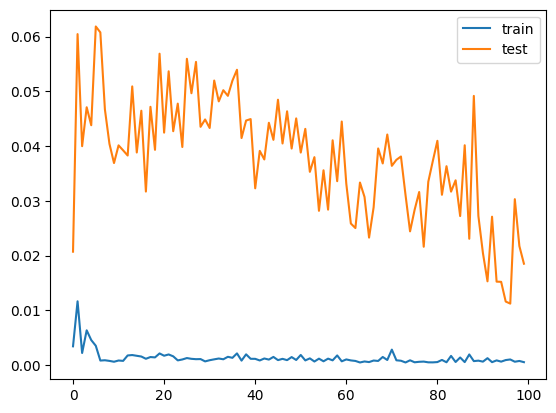

In [16]:
"""
    1. Create and train the model
    2. Plot the loss
"""

# 1. Create and train the model
lstm_model = create_LSTM_model(window + 1, 6)
history = lstm_model.fit(X_trainw, y_trainw, 
                         epochs=100, batch_size=32, 
                         validation_data=(X_testw, y_testw), 
                         verbose=1, shuffle=False)

# 2. Plot the loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



31/31 [==============================] - 0s 6ms/step


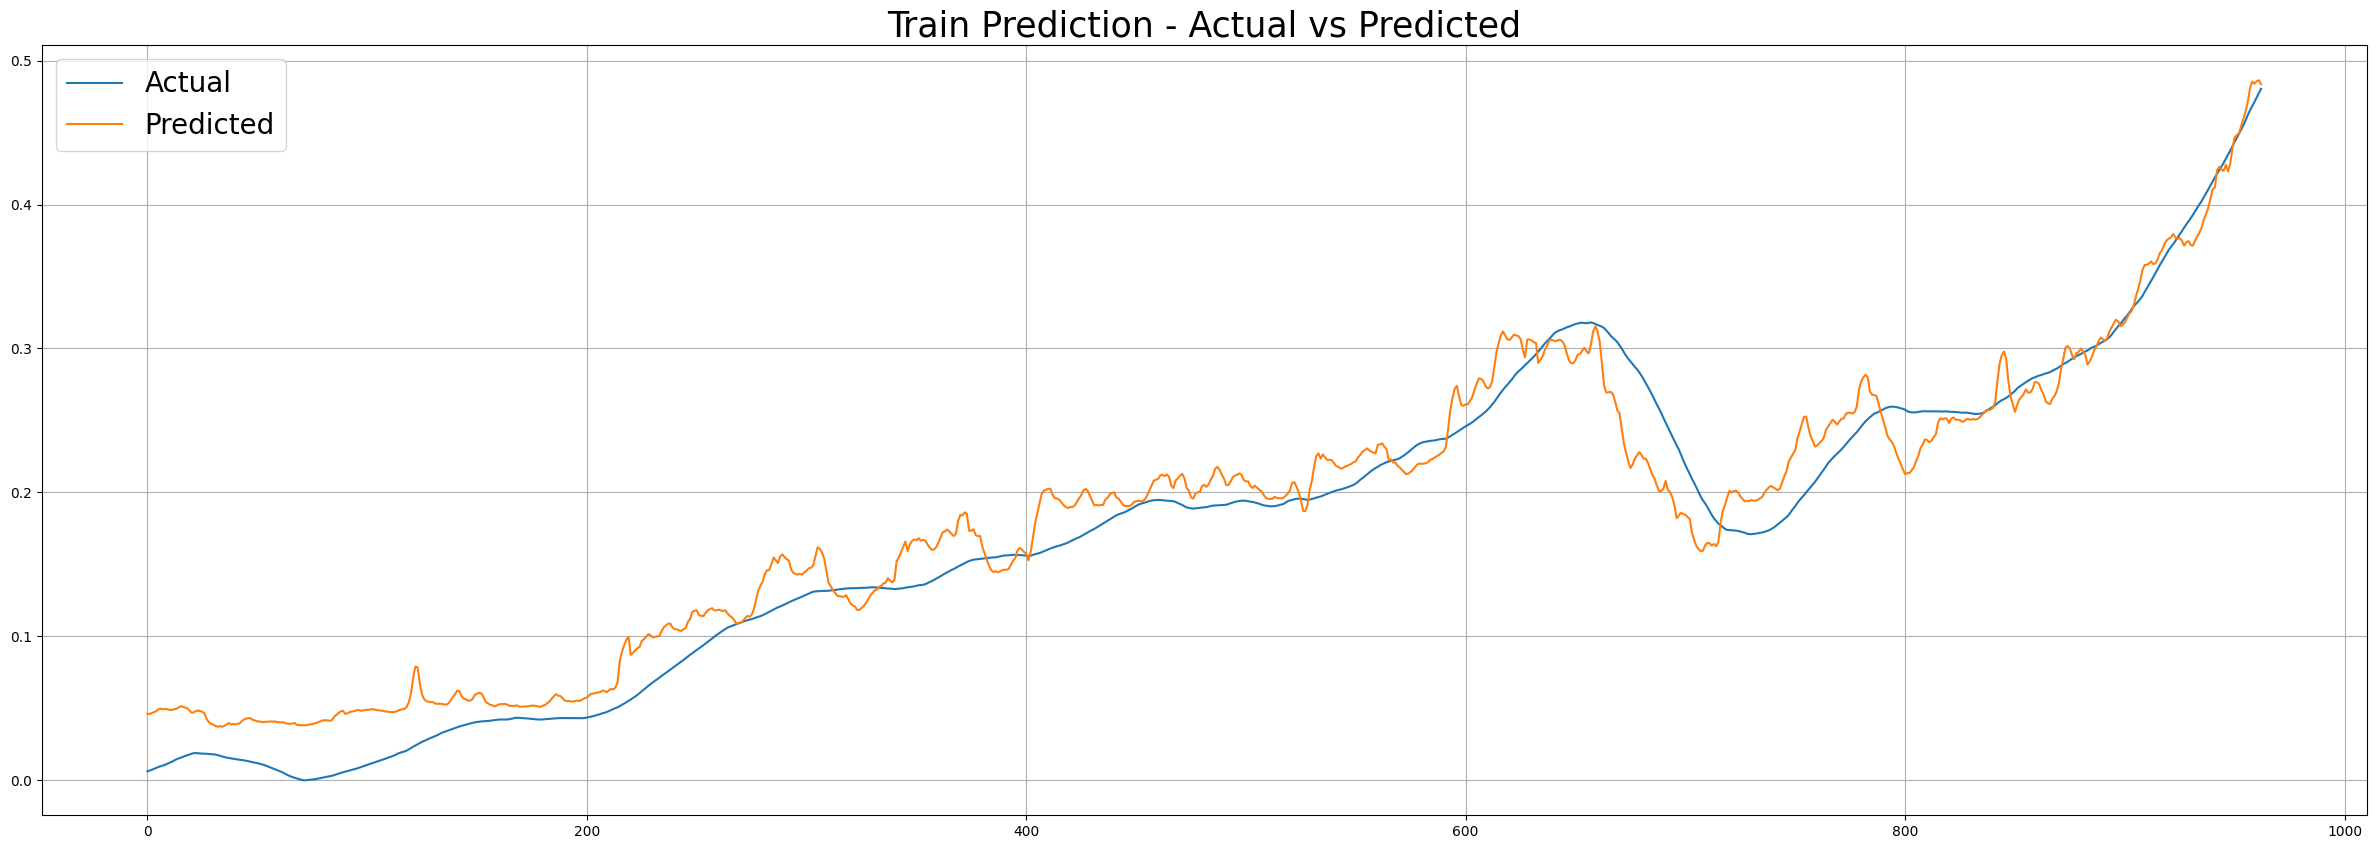

In [21]:
"""
    1. make prediction with TRAIN dataset
    2. plot the prediction
"""

# 1. make prediction
train_predict = lstm_model.predict(X_trainw)
# 2. plot the prediction
plt.figure(figsize=(30,10))
plt.plot(y_trainw, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.grid()
plt.title('Train Prediction - Actual vs Predicted', fontsize=25)
plt.legend(fontsize=20)
plt.show()